# Notes

Using spaCy
- See the deep dive guides on https://spacy.io/docs/usage/tutorials
- In particular: https://github.com/JonathanReeve/advanced-text-analysis-workshop-2017

General resources on NLP:
- Awesome curated list of resources: https://github.com/keon/awesome-nlp

Splitting up the text in chapters: https://github.com/JonathanReeve/chapterize

Possibly relevant, higher level library for spaCy interaction: https://github.com/chartbeat-labs/textacy



## Content analysis
Frequency things to look at:
- Words with interesting presence in corpus, to get a first impression.
- Presence of select terms based on that across the corpus.
- Probability measures of custom terms across the corpus.
- Chunk corpus into the separate essays and look at dispersion of frequencies.
- Visualizations 
- Comparisons with a reference corpus

Ngrams, collocations

Topical analysis:
- Most prevalent verbs and their most prevalent valency actants.
- Topic modelling

## Linguistic analysis

- Syntactical tendencies in the whole corpus and in separate texts.
- Stylometric analysis and author identification/dispersion across the texts. Correspondence with known authorships?
- Dominant syntactical structures?
- Sentence length (compared to reference corpus, modern English).
- Average nesting depth.

## Cases

Attribution dispute, cf. the [wikipedia section](https://en.wikipedia.org/wiki/The_Federalist_Papers#Disputed_essays):
- Can we replicate some of the already published studies?
- Supplement the results by other analyses? Contradict, support?

First, we need to prepare our corpus. In this case we have a very small corpus, so it would be a simple task to download the file manually through a web browser. But it is incredibly useful to be able to do it programmatically in stead. To do that we will use some functionality from the built-in Python library `urllib`.

In [33]:
from urllib import request
import os

def download_to_file(url, directory='./data', filename='download.txt'):
    web_response = request.urlopen(url)
    web_content = web_response.read().decode('utf-8')
    
    if not os.path.isdir(directory):
        os.mkdir(directory)
    full_filename = os.path.join(directory, filename)
    
    with open(full_filename, mode='w', encoding='utf-8') as f:
        f.write(web_content)
    return f

This function downloads the content of the `url` into a file. If none of the two keyword arguments are specified, the file will be saved in the current working directory with the filename `download.txt`. 

*The Federalist Papers* can be downloaded as a single plain text file from [Project Gutenberg](www.gutenberg.org). The specific address is: https://www.gutenberg.org/cache/epub/1404/pg1404.txt. 

So let's download that: 

In [34]:
federalist_file = download_to_file('https://www.gutenberg.org/cache/epub/1404/pg1404.txt', filename='federalist.txt')

In [35]:
import time

import spacy
from spacy.tokens.doc import Doc
from spacy.tokens.token import Token
from spacy.tokens.span import Span

Download the English language model before moving on with `spacy download en`. Then we can load the model.

In [36]:
nlp = spacy.load('en')

Now we initialize our document.

In [37]:
def make_doc(in_file_path) -> Doc:
    with open(in_file_path, 'r', encoding='utf-8') as file:
        text = file.read()
        doc = nlp(text)
        print('Teksten indeholder {} ord'.format(len(list(doc))))

        return doc

In [38]:
%%time
doc = make_doc(federalist_file.name)

Teksten indeholder 236196 ord
CPU times: user 10.9 s, sys: 152 ms, total: 11.1 s
Wall time: 11.1 s


In [64]:
def find_tokens(doc, lemma_, pos_=None):
    return [token for token in doc
            if token.lemma_ == lemma_ and (pos_ is None or token.pos_ == pos_)]

In [105]:
def count_tokens(*lemma):
    words = {}
    for lemma in lemma:
        words[lemma] = len(find_tokens(doc, lemma))
    return words

In [106]:
count_tokens('union', 'state', 'unite', 'honor', 'war', 'peace')


{'honor': 21,
 'peace': 113,
 'state': 1003,
 'union': 377,
 'unite': 39,
 'war': 153}

In [54]:
from collections import Counter
from typing import List, Tuple
keywords = Counter()

# On probability: The lower the value, the less likely is the word to occur ≈ the more significant 
# is its occurence. (gleaned from https://github.com/explosion/spaCy/commit/ff9ff6f3fa1fe15191233796e669028a31936dee)

def most_significant_words(doc: Doc, count: int = 35,
                           probability: int = -8) -> List[Tuple[str, int]]:
    for chunk in doc:
        # probablity value -8 is arbitrarily selected threshold
        if nlp.vocab[chunk.lemma_].prob < probability:
            keywords[chunk.lemma_] += 1

    return keywords.most_common(count)


def most_significant_verbs(doc: Doc, count: int = 35,
                           probability: int = -8) -> List[Tuple[str, int]]:
    for token in doc:
        if token.pos_ == 'VERB' and nlp.vocab[token.lemma_].prob < probability:
            keywords[token.lemma_] += 1

    return keywords.most_common(count)


def most_significant_noun_phrases(doc: Doc, count: int = 35,
                                  probability: int = -8) -> List[Tuple[str, int]]:
    for chunk in doc.noun_chunks:
        if nlp.vocab[chunk.lemma_].prob < probability:
            keywords[chunk.lemma_] += 1

    return keywords.most_common(count)



In [42]:
from pprint import pprint
pprint(most_significant_noun_phrases(doc, probability=-10, count=10))
pprint(most_significant_noun_phrases(doc, probability=-20, count=10))

[('-PRON-', 11608),
 ('the people', 1008),
 ('the union', 552),
 ('the constitution', 434),
 ('the states', 422),
 ('the power', 418),
 ('the government', 402),
 ('the state', 352),
 ('the united states', 332),
 ('the convention', 280)]
[('-PRON-', 11608),
 ('the people', 1008),
 ('the union', 552),
 ('the constitution', 434),
 ('the states', 422),
 ('the power', 418),
 ('the government', 402),
 ('the state', 352),
 ('the united states', 332),
 ('the convention', 280)]


In [55]:
pprint(most_significant_verbs(doc, probability=0, count=10))

[('ought', 275),
 ('shall', 254),
 ('find', 186),
 ('propose', 158),
 ('appear', 154),
 ('require', 145),
 ('consider', 143),
 ('give', 126),
 ('form', 122),
 ('establish', 120)]


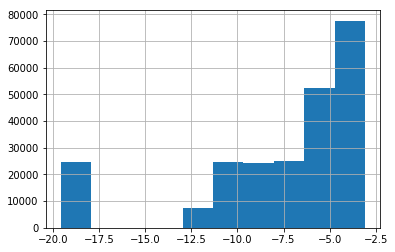

In [28]:
# How are the probabilities distributed in the text?
import pandas as pd
%matplotlib inline
probabilities = [word.prob for word in doc]
pd.Series(probabilities).hist()

From the above, it looks like the probability measure is not based on the whole corpus, but on a smaller context. Notice how the count differs based on the probability limit.